# Cálculo del PERT de un proyecto

## Datos de partida del PERT

In [1]:
import pandas as pd

In [2]:
datos_pert = pd.DataFrame({ 'A':  ( 1,   2,  2),
                            'B':  ( 1,   3,  3),
                            'C':  ( 2,   5,  4),
                            'D':  ( 4,   7,  3),
                            'E':  ( 3,   6,  5),
                            'F':  ( 7,   8,  3),
                            'G':  ( 7,  12,  1),
                            'H':  ( 8,   9,  4),
                            'I':  ( 6,  10,  2),
                            'J':  ( 5,   9,  3),
                            'K':  (10,  11,  1),
                            'L':  (10,  11,  3),
                            'M':  ( 9,  12,  2),
                            'N':  (11,  12,  3),
                            'f1': ( 3,   4,  0),
                            'f2': ( 2,   4,  0),
                            'f3': ( 6,   7,  0),
                            'f4': ( 5,   8,  0),
                          },
                          index=['nodo_inicial','nodo_final','duracion']).T

recursos = pd.Series({'A':  7,
                      'B':  7,
                      'C':  10,
                      'D':  9,
                      'E':  8,
                      'F':  7,
                      'G':  6,
                      'H':  5,
                      'I':  3,
                      'J':  2,
                      'K':  3,
                      'L':  2,
                      'M':  8,
                      'N':  9,
                      'f1': 0,
                      'f2': 0,
                      'f3': 0,
                      'f4': 0,
                     })
datos_pert['recursos'] = recursos
datos_pert

,nodo_inicial,nodo_final,duracion,recursos
A,1,2,2,7
B,1,3,3,7
C,2,5,4,10
D,4,7,3,9
E,3,6,5,8
F,7,8,3,7
G,7,12,1,6
H,8,9,4,5
I,6,10,2,3
J,5,9,3,2


In [3]:
recursos

A      7
B      7
C     10
D      9
E      8
F      7
G      6
H      5
I      3
J      2
K      3
L      2
M      8
N      9
f1     0
f2     0
f3     0
f4     0
dtype: int64

## Cálculo usando Python
### Importamos librerías de Python.
En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [4]:
from IPython.display import Image
from pmule import PertGraph


### La clase PertGraph permite calcular y visualizar el PERT

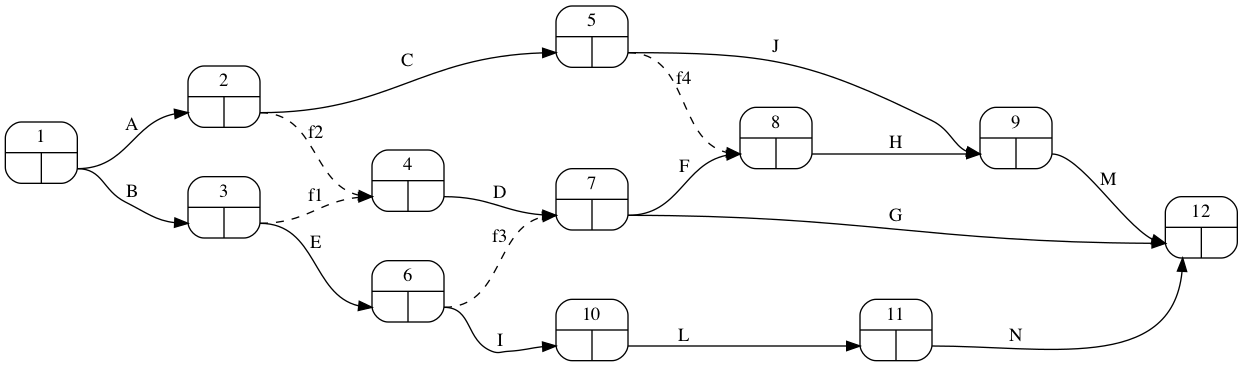

In [5]:
pert = PertGraph(datos_pert)

filename='pert_en_blanco.png'
pert.write_dot(filename=filename, orientation='portrait', tiempos=False, ranksep=1, nodesep=0.5)
Image(filename)

### Matriz de Zaderenko 

In [6]:
zaderenko = pert.zaderenko()
zaderenko

,1,2,3,5,4,7,6,8,12,9,10,11,temprano
1,,2,3,,,,,,,,,,0
2,,,,4,0,,,,,,,,2
3,,,,,0,,5,,,,,,3
5,,,,,,,,0,,3,,,6
4,,,,,,3,,,,,,,3
7,,,,,,,,3,1,,,,8
6,,,,,,0,,,,,2,,8
8,,,,,,,,,,4,,,11
12,,,,,,,,,,,,,17
9,,,,,,,,,2,,,,15


In [7]:
pert.tiempos()

,1,2,3,5,4,7,6,8,12,9,10,11
tardio,0,5,3,11,5,8,8,11,17,15,11,14
temprano,0,2,3,6,3,8,8,11,17,15,10,13


In [8]:
pert.duracion()

17

In [9]:
pert.holguras()

,H_total
nombre,
A,3
B,0
C,5
f2,3
E,0
f1,2
J,6
f4,5
D,2


In [10]:
pert.camino_critico()

{'Actividades': ['B', 'E', 'F', 'f3', 'H', 'M'],
 'Nodos': [1, 3, 6, 7, 8, 9, 12]}

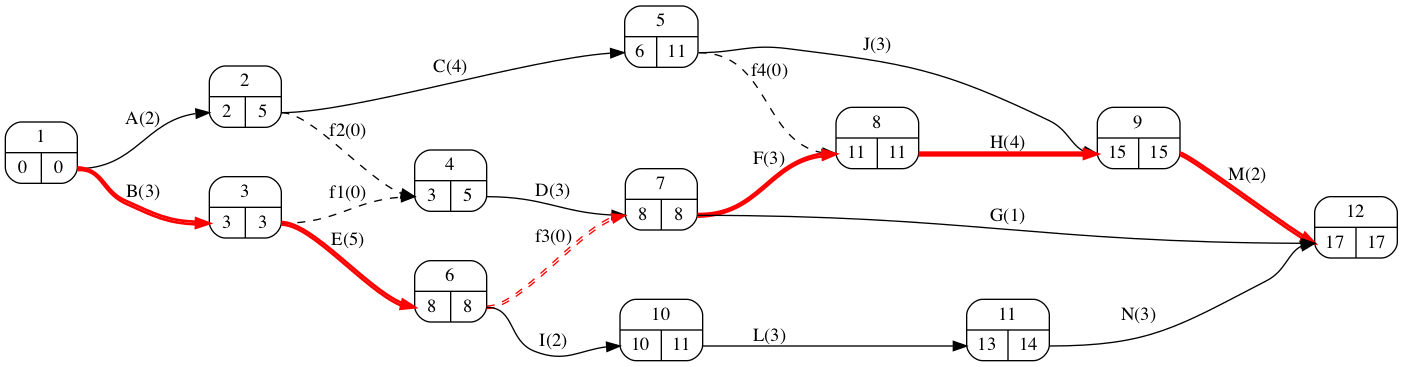

In [11]:
filename='pert_resuelto.png'
pert.write_dot(filename=filename, orientation='portrait', tiempos=True, ranksep=1, nodesep=0.5)
Image(filename)

In [12]:
pert.gantt_recursos()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
A,7,7,,,,,,,,,,,,,,,
B,7,7,7,,,,,,,,,,,,,,
C,,,10,10,10,10,,,,,,,,,,,
E,,,,8,8,8,8,8,,,,,,,,,
J,,,,,,,2,2,2,,,,,,,,
D,,,,9,9,9,,,,,,,,,,,
F,,,,,,,,,7,7,7,,,,,,
G,,,,,,,,,6,,,,,,,,
I,,,,,,,,,3,3,,,,,,,
H,,,,,,,,,,,,5,5,5,5,,
